## Efficient assembly and differentiation of NVAR nonlinear state vector

#### By: Sam Hocking

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import warnings

from cmlCore import *
from cmlUtils import *

np.set_printoptions(edgeitems=10, linewidth=100000, threshold=sys.maxsize)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

from math import factorial
from copy import deepcopy

In [2]:
def n_choose_k(n,k):
    return factorial(n)/(factorial(n-k)*factorial(k))

def n_multichoose_k(n,k):
    return n_choose_k(n+k-1,k)

def n_multichoose_l_levels(n,l):
    return sum([n_multichoose_k(n,k) for k in range(1,l+1)])

def basisVectRn(i,n):
    e = np.zeros(n)
    e[i] = 1
    return e

In [3]:
def make_polynomial_comb_func_multiindex(k, d, max_order):
    l = k*d
    A = np.eye(l)
    for i in range(max_order-1):
        A0 = A
        for j in range(l):
            ej = basisVectRn(j, l)
            B = deepcopy(A0)
            for x in B:
                x += ej
            A = np.vstack((A, B))
    ALPHA = np.vstack([np.zeros(l),A])
    ALPHA, idx = np.unique(ALPHA,axis=0,return_index=True)
    ALPHA = ALPHA[np.argsort(idx)]
    return ALPHA

def make_polynomial_comb_deriv_multiindex(func_multiindex):
    ALPHA = func_multiindex
    m = ALPHA.shape[0]
    l = ALPHA.shape[1]
    D_ALPHA = np.zeros((m,l,l+1))

    # iterate through rows
    for i in range(m): 
        # iterate through linear variables
        for j in range(l):
            # check if multi-index of jth linear variable is > 0 (linear or higher dependence)
            if ALPHA[i,j] > 0:
                D_ALPHA[i,j,0] = ALPHA[i,j]
                D_ALPHA[i,j,1:] = np.max([ALPHA[i,:]-basisVectRn(j,l),np.zeros(l)],axis=0)
    return D_ALPHA

def make_state_vector(linear, ALPHA):
    # return np.array([[np.product(linear ** x)] for x in ALPHA])
    return np.array([np.product(linear ** x) for x in ALPHA])

def make_state_vector_gradient_matrix(linear, D_ALPHA):
    return np.array([np.array([D_ALPHA[i,j,0]*np.product(linear ** D_ALPHA[i,j,1:]) for j in range(l)]) for i in range(len(D_ALPHA))])

In [4]:
def getGradStateVector(h, k, d):
    h_dtype = h.dtype
    m = len(h)
    bias_indices = np.array([0])
    b = len(bias_indices)
    linear_indices = np.arange(b,1+k*d)
    l = len(linear_indices)
    nonlinear_indices = np.arange(b+l,b+l+int(k*d*(k*d + 1)/2))
    n = len(nonlinear_indices)
    linear = h[linear_indices]
    G = np.zeros((m, l)).astype(h_dtype)
    G[b:b+l] += np.eye(l)
    cumulative_ctr = b+l
    for i in range(l):
        G[cumulative_ctr:cumulative_ctr+(l-i),i:] += linear[i]*np.eye(l-i)
        G[cumulative_ctr:cumulative_ctr+(l-i),i] += linear[i:]
        cumulative_ctr += l-i
    return G

def d_hlin_dt(h, k, d, ODE):
    h_dtype = h.dtype
    m = len(h)
    bias_indices = np.array([0])
    b = len(bias_indices)
    linear_indices = np.arange(b,1+k*d)
    l = len(linear_indices)
    nonlinear_indices = np.arange(b+l,b+l+int(k*d*(k*d + 1)/2))
    n = len(nonlinear_indices)
    linear = h[linear_indices]
    out = np.zeros(l).astype(h_dtype)
    for i in range(k):
        out[i*d:(i+1)*d] = ODE(linear[i*d:(i+1)*d])
    return out

def d_yhat_dt(w, h, k, d, ODE):
    return w.T @ getGradStateVector(h, k, d) @ d_hlin_dt(h, k, d, ODE)

In [5]:
# l linear variables
# multi-index for derivative has l entries (one for each linear variable) + a coefficient
# try keeping in a 1+l vector
# let m be length of state vector
# derivative multi-index tensor is m x l x (1 + l)
# ith derivative computed by assigning ALPHA(i) as coefficient and reducing ALPHA(i) by one (assuming ALPHA(i) was > 0 to start with)

(91, 12)
(91, 12, 13)


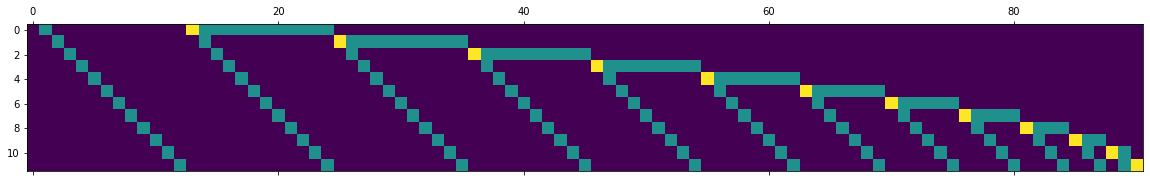

In [6]:
k = 4
d = 3
l = k * d
max_order = 2

ALPHA = make_polynomial_comb_func_multiindex(k, d, max_order)
D_ALPHA = make_polynomial_comb_deriv_multiindex(ALPHA)
print(ALPHA.shape)
print(D_ALPHA.shape)

fig, ax = plt.subplots(figsize=(20,20))
ax.matshow(ALPHA.T)

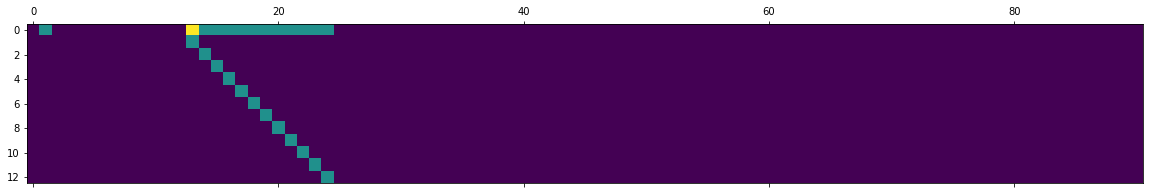

In [7]:
# e.g. partials of x1(t)
fig, ax = plt.subplots(figsize=(20,20))
ax.matshow(D_ALPHA[:,0,:].T)

In [8]:
symb_state = get_symbolic_state_labels(
    k=k,
    d=d,
    nonlinearFunc = quadraticCombination,
    extraNonlinearFunc = None
)

In [9]:
linear = symb_state[symb_state[:,1]=='linear',0]
linear

array([x(t)_1, x(t)_2, x(t)_3, x(t-s)_1, x(t-s)_2, x(t-s)_3, x(t-2s)_1, x(t-2s)_2, x(t-2s)_3, x(t-3s)_1, x(t-3s)_2, x(t-3s)_3], dtype=object)

In [38]:
make_state_vector(linear, ALPHA)

array([1, x(t)_1**1.0, x(t)_2**1.0, x(t)_3**1.0, x(t-s)_1**1.0, x(t-s)_2**1.0, x(t-s)_3**1.0, x(t-2s)_1**1.0, x(t-2s)_2**1.0, x(t-2s)_3**1.0, x(t-3s)_1**1.0, x(t-3s)_2**1.0, x(t-3s)_3**1.0, x(t)_1**2.0, x(t)_1**1.0*x(t)_2**1.0, x(t)_1**1.0*x(t)_3**1.0, x(t)_1**1.0*x(t-s)_1**1.0, x(t)_1**1.0*x(t-s)_2**1.0, x(t)_1**1.0*x(t-s)_3**1.0, x(t)_1**1.0*x(t-2s)_1**1.0, x(t)_1**1.0*x(t-2s)_2**1.0, x(t)_1**1.0*x(t-2s)_3**1.0, x(t)_1**1.0*x(t-3s)_1**1.0, x(t)_1**1.0*x(t-3s)_2**1.0, x(t)_1**1.0*x(t-3s)_3**1.0, x(t)_2**2.0, x(t)_2**1.0*x(t)_3**1.0, x(t)_2**1.0*x(t-s)_1**1.0, x(t)_2**1.0*x(t-s)_2**1.0, x(t)_2**1.0*x(t-s)_3**1.0, x(t)_2**1.0*x(t-2s)_1**1.0, x(t)_2**1.0*x(t-2s)_2**1.0, x(t)_2**1.0*x(t-2s)_3**1.0, x(t)_2**1.0*x(t-3s)_1**1.0, x(t)_2**1.0*x(t-3s)_2**1.0, x(t)_2**1.0*x(t-3s)_3**1.0, x(t)_3**2.0, x(t)_3**1.0*x(t-s)_1**1.0, x(t)_3**1.0*x(t-s)_2**1.0, x(t)_3**1.0*x(t-s)_3**1.0, x(t)_3**1.0*x(t-2s)_1**1.0, x(t)_3**1.0*x(t-2s)_2**1.0, x(t)_3**1.0*x(t-2s)_3**1.0, x(t)_3**1.0*x(t-3s)_1**1.0, x(t)_

In [10]:
make_state_vector_gradient_matrix(linear, D_ALPHA)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1.00000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1.00000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1.00000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1.00000000000000, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1.00000000000000, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1.00000000000000, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1.00000000000000, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1.00000000000000, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1.00000000000000, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1.00000000000000, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.00000000000000, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.00000000000000],
       [2.0*x(t)_1**1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1.0*x(t)_2**1.0, 1.0*x(t)_1**1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1.0*x(t)_3**1.0, 0, 1.0*x(t)_1**1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1.0*x(t-s)_1**1.0, 0, 

In [20]:
T = 300
dt = 0.01
d = 3

lorenz = np.loadtxt(f'./datasets/py-lorenz_RK4_T={T}_dt={dt}.csv', delimiter=",", dtype='float64')

# c = 1/50
# feature_mean = lorenz[:,1:].mean(axis=0)
# target_mean = lorenz[1:,1:].mean(axis=0)

raw_data = lorenz[:,1:]
raw_target = lorenz[1:,1:]

data = raw_data
target = raw_target

# data = np.tanh((lorenz[:,1:]-feature_mean)*c)
# target = np.tanh((lorenz[1:,1:]-target_mean)*c)

k=4
# k=8
# k=12
# k=16

train_start=14000
# train_start=16500
# train_start=22000
train_end=24000
test_start=train_end
test_end=26000

training_target = target[train_start:train_end]
test_target = target[test_start:test_end]
train_indices = np.arange(train_start,train_end)
test_indices = np.arange(test_start,test_end)

In [21]:
dy_dt = simple_dlorenz()

In [32]:
old_model = NVARModel(k=k, s=4, reg=1e-5, nonlinearFunc=quadraticCombination, natural_dt=0.01)

In [33]:
old_model.train(
        data,
        target,
        train_indices,
        dataLossFactor=1,
        ODELossFactor=0,
        ODEFunc=dy_dt,
        printResults=True
        )

                    MSE     NMSE    NRMSE        Loss Weighted Loss
Component                                                          
Data           0.000000 0.000000 0.000000    0.000001      0.000001
ODE            0.256097 0.000022 0.001417 2560.457629      0.000000
Regularization 0.003610 0.003610 0.060079    0.985405      0.000010
Total          0.259707 0.003632 0.061497 2561.443035      0.000011


In [34]:
model = PolyCombNVARModel(k=k, s=4, reg=1e-5, max_order=2, d=3, natural_dt=dt)

In [35]:
model.train(
        data,
        target,
        train_indices,
        dataLossFactor=1,
        ODELossFactor=0,
        ODEFunc=dy_dt,
        printResults=True
        )

                        MSE     NMSE    NRMSE             Loss Weighted Loss
Component                                                                   
Data               0.000000 0.000000 0.000000         0.000001      0.000001
ODE            11575.340262 0.995955 0.301307 115753402.621773      0.000000
Regularization     0.003610 0.003610 0.060079         0.985405      0.000010
Total          11575.343872 0.999564 0.361386 115753403.607179      0.000011


valid time : 1130


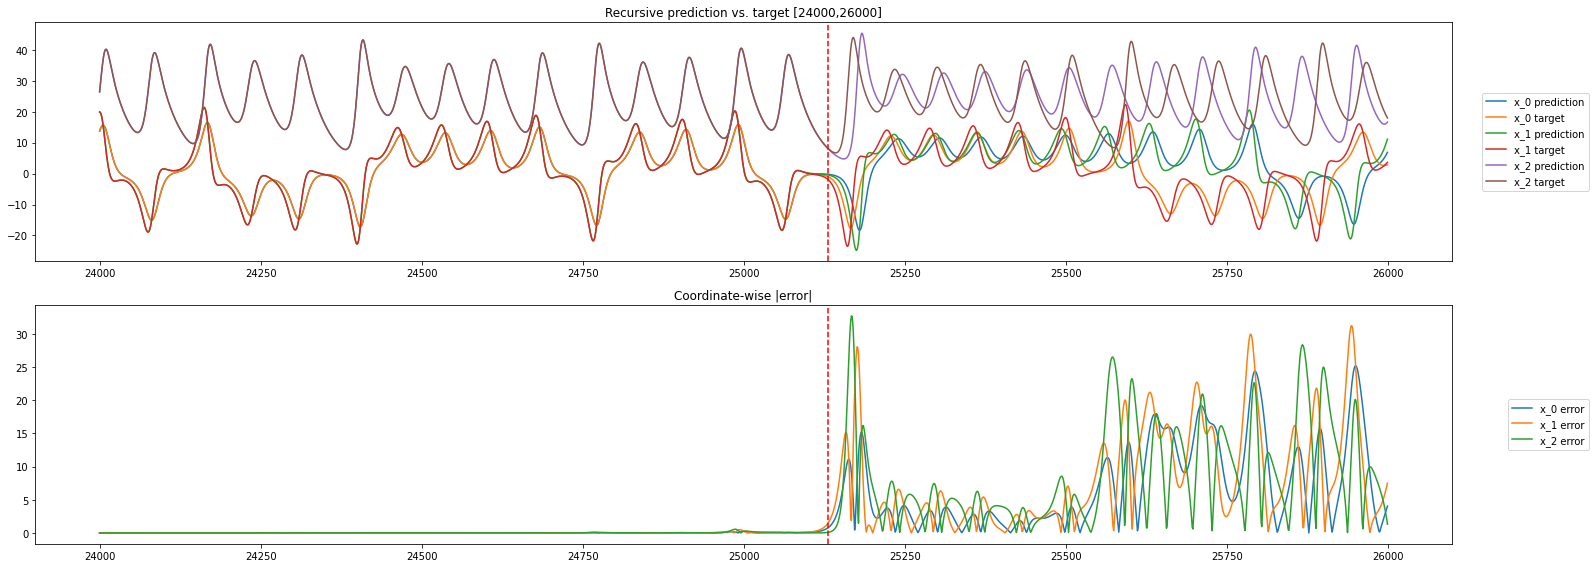

In [36]:
t_forward = 2000
recursive_out = old_model.recursive_predict(data, train_start, train_end, t_forward)

vt = validTime(0.2)(recursive_out, target[test_start:test_start+t_forward])

print(f'valid time : {vt}')
# print(f'NMSE       : {NMSE(recursive_out, target[test_start:test_start+t_forward])}')
# print(f'RMSE       : {RMSE(recursive_out, target[test_start:test_start+t_forward])}')
# print(f'NRMSE      : {NRMSE(recursive_out, target[test_start:test_start+t_forward])}')
plotRecursiveComparison(recursive_out, data, train_end, t_forward, vline_x=test_start+vt)

valid time : 1130


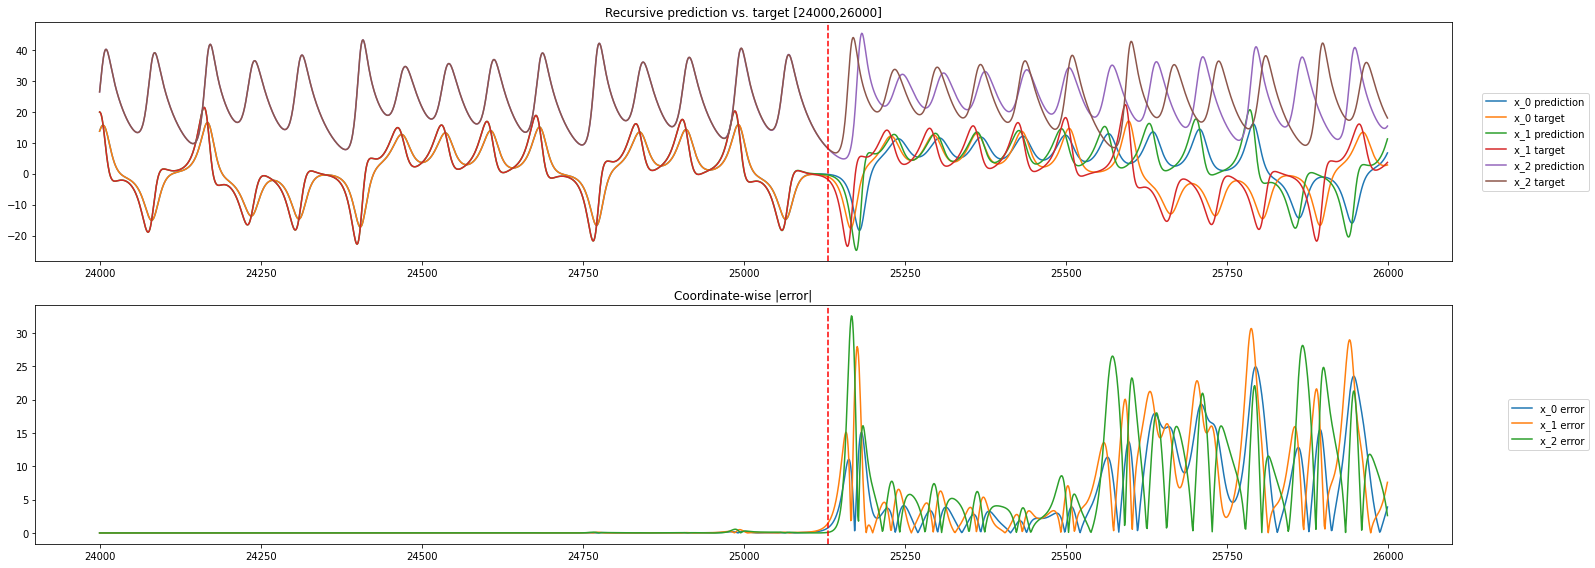

In [37]:
t_forward = 2000
recursive_out = model.recursive_predict(data, train_start, train_end, t_forward)

vt = validTime(0.2)(recursive_out, target[test_start:test_start+t_forward])

print(f'valid time : {vt}')
# print(f'NMSE       : {NMSE(recursive_out, target[test_start:test_start+t_forward])}')
# print(f'RMSE       : {RMSE(recursive_out, target[test_start:test_start+t_forward])}')
# print(f'NRMSE      : {NRMSE(recursive_out, target[test_start:test_start+t_forward])}')
plotRecursiveComparison(recursive_out, data, train_end, t_forward, vline_x=test_start+vt)